In [1]:
using CSV, DataFrames
using Plots
using Dates
using BenchmarkTools
using JuMP, HiGHS

## Optimization model for storage system scheduling - LP relaxation

In [2]:
function schedule_opt(t_set, soe_min, soe_max, p_c_max, p_d_max, prices, ρ, η_c, η_d, soe_init, test_simult)
    model = Model(HiGHS.Optimizer)
    nb_t = length(t_set)

    @variables model begin
            soe_min <= soe[t in 1:nb_t] <= soe_max
            0 <= p_c[t in 1:nb_t] <= p_c_max
            0 <= p_d[t in 1:nb_t] <= p_d_max
        end

    @objective(model, Max, sum(prices[t]*(p_d[t]-p_c[t]) for t in 1:nb_t))

    @constraints model begin
        StorageBalance[t in 2:nb_t],
            soe[t] == ρ * soe[t-1] + η_c * p_c[t] - (1/η_d) * p_d[t]
        StorageBalance_init,
            soe[1] == ρ * soe_init + η_c * p_c[1] - (1/η_d) * p_d[1]
    end
    if test_simult >= 1
        @constraint(model, p_d[test_simult]==0.2)
    end

    set_silent(model)
    optimize!(model)
    println(termination_status(model))

    soe_val=[]
    charge=[]
    discharge=[]
    profit_cumul_old = 0
    for t in 1:nb_t
        append!(charge,JuMP.value.(p_c[t]))
        append!(discharge,JuMP.value.(p_d[t]))
        append!(soe_val,JuMP.value.(soe[t]))
    end
    obj = JuMP.objective_value(model)

    return soe_val, obj, charge, discharge
end
;

## Example 1

### Example 1.1.a: Positive prices, no simultaneous charge and discharge

In [3]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0
soe_max = 1
soe_init = 0.0
final_level = 0.0
η_c = 0.9
η_d = 0.9
p_c_max = 1.5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
p_d_max = p_c_max
ρ = 1
# 26th May 2023
t_start = 3480
t_end = 3503
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [4]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL


Profit: 131.76€

In [5]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[14.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[14.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[14.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

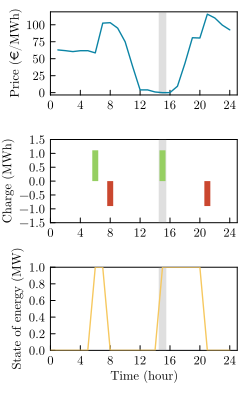

In [6]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [7]:
savefig("Example_1_1_a.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_1_1_a.pdf"

### Example 1.1.b: Positive prices, simultaneous charge and discharge

In [8]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 1.5 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 26th May 2023
t_start = 3480
t_end = 3503
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = 15 # force discharge at time period 15
;

In [9]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 131.76€


In [10]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[14.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[14.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[14.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

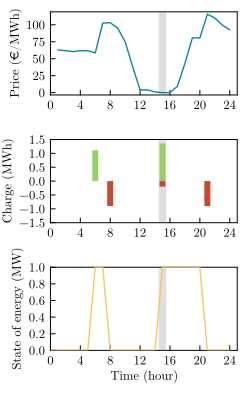

In [11]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [12]:
savefig("Example_1_1_b.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_1_1_b.pdf"

### Example 1.2: Negative prices, no inefficiencies

In [13]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 1
η_d = 1
p_c_max = 0.6 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 25th March 2023
t_start = 1993
t_end = 2016
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
#test_simult = 13 # force discharge at time period 13
;

In [14]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 84.14€


In [15]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

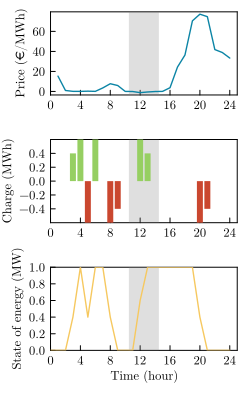

In [16]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [17]:
savefig("Example_1_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_1_2.pdf"

### Example 1.3: Negative prices, inefficiencies

In [18]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.6 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 25th March 2023
t_start = 1993
t_end = 2016
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [19]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 76.12€


In [20]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

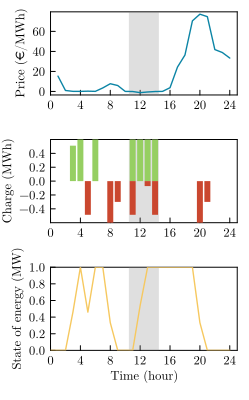

In [21]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [22]:
savefig("Example_1_3.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_1_3.pdf"

### Example 1.4: Negative prices, inefficiencies, slow

In [95]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.2 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 25th March 2023
t_start = 1993
t_end = 2016
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [96]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 60.43€

In [97]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

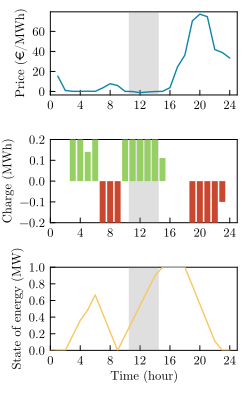

In [98]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [99]:
savefig("Example_1_4.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_1_4.pdf"

## Example 2

### Example 2.1: Fast storage

In [28]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 2.0 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 1st January 2023
t_start = 1
t_end = 24
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [29]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 51.22€


In [30]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[6.5, 7.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[6.5, 7.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[6.5, 7.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

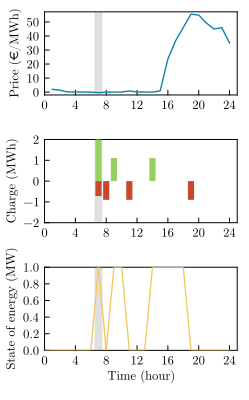

In [31]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [32]:
savefig("Example_2_1.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_2_1.pdf"

### Example 2.2: Slow storage

In [33]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.6 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 1st January 2023
t_start = 1
t_end = 24
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [34]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 50.54€


In [35]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[6.5, 7.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[6.5, 7.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[6.5, 7.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

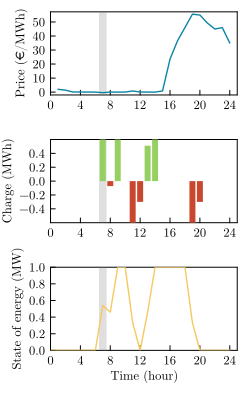

In [36]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [37]:
savefig("Example_2_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_2_2.pdf"

## Example 3

### Example 3.1: Simultaneous charge and discharge

In [38]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.036 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 7-9th July
t_start = 5255
t_end = 5286
n_max=32
T = [t_start:t_end;]
T_plt = [0:t_end-t_start+1;]
test_simult = false
;

In [39]:
# Check system 

model = Model(HiGHS.Optimizer)

@variable(model, n >= 0, Int)
@variable(model, m >= 0, Int)
@variable(model, soe_min <= s <= soe_max)

@objective(model, Max, 1)

@constraint(model, m+n==n_max)
@constraint(model, s + n*η_c * p_c_max - (m/η_d) * p_d_max == soe_max)
@constraint(model, s==soe_init)

set_silent(model)
optimize!(model)
println(termination_status(model))

INFEASIBLE


In [40]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 5.49€


In [41]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

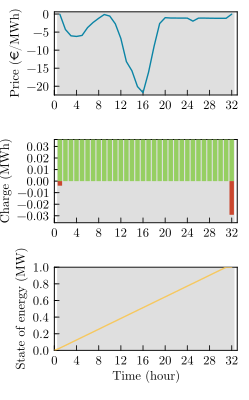

In [42]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [43]:
savefig("Example_3_1.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_3_1.pdf"

### Example 3.2: No simultaneous charge and discharge

In [44]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.034 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 7-9th July
t_start = 5255
t_end = 5286
T = [t_start:t_end;]
T_plt = [0:t_end-t_start+1;]
test_simult = false
;

In [45]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 5.19€


In [46]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

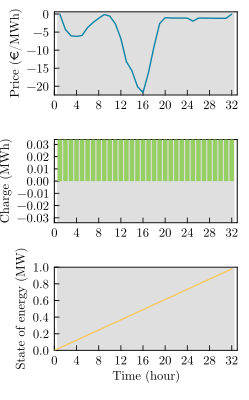

In [47]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [48]:
savefig("Example_3_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_3_2.pdf"

#### Example 3.2.2: Simultaneous charge and discharge with close blocks

In [49]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.034 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = 0.028 # MW
ρ = 1
# 7-9th July
t_start = 5244
t_end = 5286
T = [t_start:t_end;]
T_plt = [0:t_end-t_start+1;]
test_simult = false
;

In [50]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 6.05€


In [51]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,T_plt[end]+1), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,T_plt[end]+1), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,T_plt[end]+1), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[11.5, 43.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[11.5, 43.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[11.5, 43.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)

vspan!(plt_price,[0.5, 6.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[0.5, 6.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[0.5, 6.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

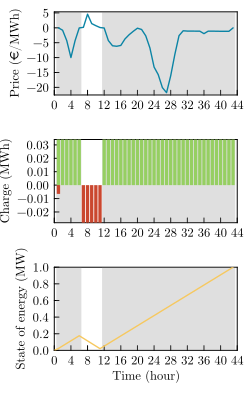

In [52]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [53]:
savefig("Example_3_2_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_3_2_2.pdf"

### Example 3.3: Special case

In [54]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.036 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = 31 *0.81 * p_c_max - 0.9 # MW
ρ = 1
# 7-9th July
t_start = 5255
t_end = 5286
prices[5274,:Price] = -0.01
n_max=32
T = [t_start:t_end;]
T_plt = [0:t_end-t_start+1;]
test_simult = false
;

In [55]:
p_d_max

0.0039599999999999635

In [56]:
# Check system 

model = Model(HiGHS.Optimizer)

@variable(model, n >= 0, Int)
@variable(model, m >= 0, Int)
@variable(model, soe_min <= s <= soe_max)

@objective(model, Max, 1)

@constraint(model, m+n==n_max)
@constraint(model, s + n*η_c * p_c_max - (m/η_d) * p_d_max == soe_max)
@constraint(model, s==soe_init)

set_silent(model)
optimize!(model)
println(termination_status(model))

OPTIMAL


In [57]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 5.46€


In [58]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,33), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[0.5, 32.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

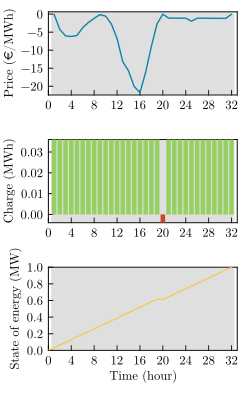

In [59]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [60]:
savefig("Example_3_3.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_3_3.pdf"

#### Example 3.3.2: Simultaneous charge and discharge with close blocks

In [61]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.036 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = 31 *0.81 * p_c_max - 0.9 # MW
ρ = 1
# 7-9th July
t_start = 5244
t_end = 5286
prices[5274,:Price] = -0.01
T = [t_start:t_end;]
T_plt = [0:t_end-t_start+1;]
test_simult = false
;

In [62]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 6.18€


In [63]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,T_plt[end]+1), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,T_plt[end]+1), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,T_plt[end]+1), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[11.5, 43.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[11.5, 43.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[11.5, 43.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)

vspan!(plt_price,[0.5, 6.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[0.5, 6.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[0.5, 6.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

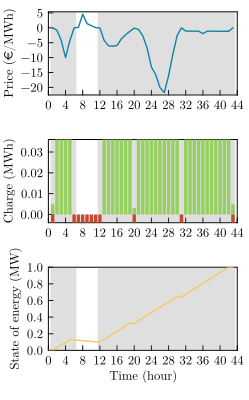

In [64]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [65]:
savefig("Example_3_3_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_3_3_2.pdf"

## Example 4

### Example 4.1: No simultaneous charge and discharge

In [66]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.27 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 25th March 2023
t_start = 1993
t_end = 2016
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [67]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 68.82€


In [68]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

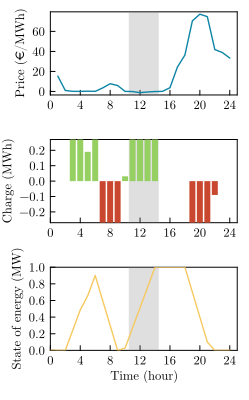

In [69]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [70]:
savefig("Example_4_1.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_4_1.pdf"

### Example 4.2: Reaching minimum is not possible

In [71]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 1.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.27 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = 0.08 # MW
ρ = 1
# 25th March 2023
t_start = 1993
t_end = 2016
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [72]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 35.31€

In [73]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

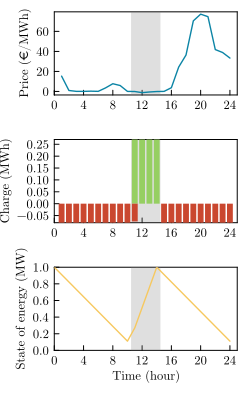

In [74]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [75]:
savefig("Example_4_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_4_2.pdf"

### Example 4.3: Fast charge

In [76]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 1.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.28 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = 0.27 # MW
ρ = 1
# 25th March 2023
t_start = 1993
t_end = 2016
T = [t_start:t_end;]
T_plt = [0:24;]
test_simult = false
;

In [77]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 73.35€


In [78]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,25), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[10.5, 14.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

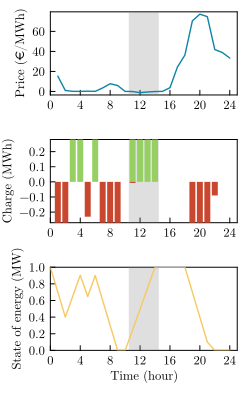

In [79]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(250,400))

In [80]:
savefig("Example_4_3.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_4_3.pdf"

## Example 5

### Example 5.1: Fast charge

In [81]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.2 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 27th-29th May 2023
t_start = 3504
t_end = 3575
T = [t_start:t_end;]
T_plt = [0:72;]
test_simult = false
;

In [82]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 397.54€


In [83]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,73), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,73), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,73), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[13.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[13.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[13.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)

vspan!(plt_price,[34.5, 42.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[34.5, 42.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[34.5, 42.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)

vspan!(plt_price,[58.5, 66.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[58.5, 66.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[58.5, 66.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

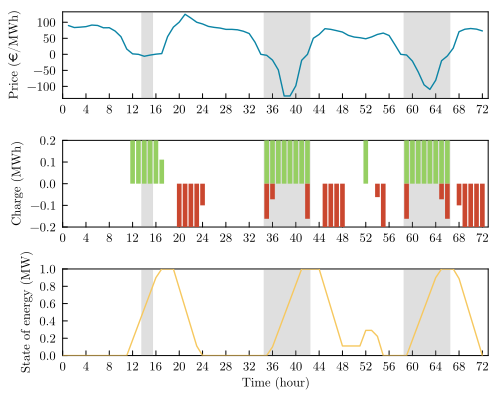

In [84]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(500,400))

In [85]:
savefig("Example_5_1.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_5_1.pdf"

### Example 5.1: Slow charge

In [86]:
# Import data
file_name = string("Day-ahead Prices_2023.csv")
prices = DataFrame(CSV.File(file_name; select=["Price"]))

## Parameters
soe_min = 0 # MWh
soe_max = 1 # MWh
soe_init = 0.0 # MWh
η_c = 0.9
η_d = 0.9
p_c_max = 0.1 # MW                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
p_d_max = p_c_max # MW
ρ = 1
# 27th-29th May 2023
t_start = 3504
t_end = 3575
T = [t_start:t_end;]
T_plt = [0:72;]
test_simult = false
;

In [87]:
# Run the optimization
soe_val, profit, charge_val, discharge_val = schedule_opt(T, soe_min, soe_max, p_c_max, p_d_max, prices[T,:Price], ρ, η_c, η_d, soe_init, test_simult)
println("Profit: ", round(profit,digits=2),"€")
# Add initial values for plotting
soe_plt = append!([soe_init],soe_val)
charge_plt = append!([NaN], charge_val)
discharge_plt = append!([NaN], -discharge_val) #  Opposite of discharge to appear as negative on the plots
prices_plt = append!([NaN], prices[T,:Price])
;

OPTIMAL
Profit: 236.1€


In [88]:
##Set-up plot
theme(:dao)
plt_ch_dch = bar(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,73), ylimits=(-p_d_max,p_c_max), xticks=0:4:72, ylabel = "Charge (MWh)", guidefontsize=8, tickfontsize=8)
plt_price = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,73), xticks=0:4:72, ylabel = "Price (€/MWh)", guidefontsize=8, tickfontsize=8)
plt_soe = plot(legend=:outerright, grid=:false, minorticks=:false, xlimits=(0,73), ylimits=(0,1), xticks=0:4:72, xlabel="Time (hour)", ylabel = "State of energy (MW)", guidefontsize=8, tickfontsize=8)
# Plot
# Grey areas to identify negative prices
vspan!(plt_price,[13.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[13.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[13.5, 15.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)

vspan!(plt_price,[34.5, 42.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[34.5, 42.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[34.5, 42.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)

vspan!(plt_price,[58.5, 66.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_ch_dch,[58.5, 66.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
vspan!(plt_soe,[58.5, 66.5], linecolor = :grey, fillcolor = :grey,alpha=0.25)
# Plots
bar!(plt_ch_dch,T_plt,charge_plt, linecolor=nothing, label="Charge (MWh)", color="#96CF62")
bar!(plt_ch_dch,T_plt,discharge_plt, linecolor=nothing, label="Discharge (MWh)", color=:"#CA472F")
plot!(plt_soe,T_plt,soe_plt, label="State of energy (MW)", color="#F6C85F")
plot!(plt_price, T_plt, prices_plt, label="Prices (€/MWh)", color="#0B84A5")
;

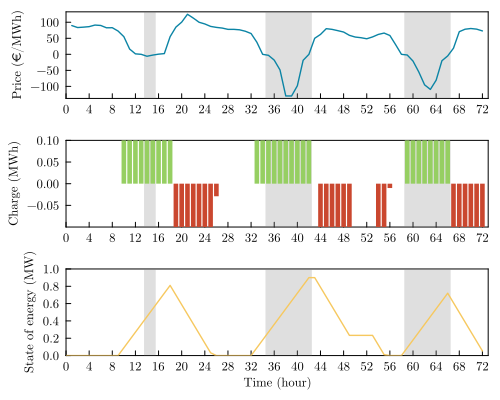

In [89]:
plot(plt_price, plt_ch_dch, plt_soe, layout = (3,1), legend=false, size=(500,400))

In [90]:
savefig("Example_5_2.pdf")

"c:\\Users\\emapr\\OneDrive - Danmarks Tekniske Universitet\\Storage Scheduling\\Simultaneous CD - Final code paper\\Example_5_2.pdf"